In [1]:
# Colab Setup (Run this first)

In [2]:
!pip install litebird_sim rich

# `litebird_sim` beam convolution

To run this notebook, you have several options:

-   If you are running this under Binder, you should already be set!
-   If you are running this under Google Colab, be sure to run the cell with `!pip install…` that is right above the title.
-   If you are running this locally, you should first create and activate a new virtual environment with the commands

    ```
    python -m venv ./my_venv
    source ./my_venv/bin/activate
    ```

    (you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

    ```
    pip install jupyter litebird_sim
    ```

    If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a _development install_ instead:

    ```
    cd /my/local/copy/litebird_sim
    pip install -e .
    ```


## Set up the environment


In [3]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide

We start by importing a few libraries that will be useful in this notebook.


In [4]:
import litebird_sim as lbs
import numpy as np

import matplotlib.pylab as plt
import astropy
import healpy as hp

%matplotlib inline

In [5]:
lbs.PTEP_IMO_LOCATION

PosixPath('/Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/litebird_sim/default_imo/schema.json.gz')

## Parameters of the simulation

We will simulate a pair of 140 GHz LFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version vPTEP (**new!**), and we will simulate 6 months of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.


In [6]:
telescope = "LFT"
channel = "L4-140"
detlist = [
    "000_001_017_QB_140_T",
    "000_001_017_QB_140_B",
]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 365

imo_version = "vPTEP"

# Resolution of the output maps
nside = 256

# beams
fwhm_arcmin = 30.0
ellipticity = 1

# paramters for the generation of the input CMB and for the convolution
lmax = 3 * nside - 1
mmax = 4

To use the IMO bundled in `litebird_sim`, one needs to do the following:


In [7]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    imo=imo,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.


In [8]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []  # type: list[lbs.DetectorInfo]
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 6 months tod without taking too much memory
    det.sampling_rate_hz = 2

    det.ellipticity = ellipticity
    det.fwhm_arcmin = fwhm_arcmin

    dets.append(det)

# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

## Initialize TODs

Here we initialize a pair of TODs for scan_map and for convolve_sky

In [9]:
(obs,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
    tods=[
        lbs.TodDescription(
            name="scan_map",
            description="CMB",
            dtype=np.float64,
            units=lbs.Units.K_CMB,
        ),
        lbs.TodDescription(
            name="convolve_sky",
            description="CMB",
            dtype=np.float64,
            units=lbs.Units.K_CMB,
        ),
    ],
)

Let's now perepare the pointings, in this case we do not initialize the HWP


In [10]:
sim.prepare_pointings()

## Generate inputs

We generate maps and alms using [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps)

In [11]:
# let's make an input CMB map, smoothing the maps by the proper gaussian beam

sky_params = lbs.SkyGenerationParams(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    apply_beam=True,  # if True, smooths the input map by the beam of the channel
    bandpass_integration=False,  # if True, integrates over the top-hat bandpass of the channel
    units="K_CMB",
    output_type="map",
    nside=nside,
)

map_sky = sim.get_sky(parameters=sky_params)

sky_params = lbs.SkyGenerationParams(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    apply_beam=True,
    bandpass_integration=False,
    units="K_CMB",
    output_type="alm",
    lmax=lmax,
)

alm_sky_smooth = sim.get_sky(parameters=sky_params)

# let's make an input CMB alms, in this case we don't apply any beam

sky_params = lbs.SkyGenerationParams(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    apply_beam=False,
    bandpass_integration=False,
    units="K_CMB",
    output_type="alm",
    lmax=lmax,
)

alm_sky = sim.get_sky(parameters=sky_params)

[2026-01-19 23:19:35,519 INFO MPI#0000] Generating CMB...
[2026-01-19 23:19:35,740 INFO MPI#0000] Summing components...
[2026-01-19 23:19:35,749 INFO MPI#0000] Generating CMB...
[2026-01-19 23:19:35,879 INFO MPI#0000] Summing components...
[2026-01-19 23:19:35,883 INFO MPI#0000] Generating CMB...
[2026-01-19 23:19:35,986 INFO MPI#0000] Summing components...


## Fill TODs 

Now we can fill the TODs with the appropriate sky signal.

Here we both use [fill_tods](https://litebird-sim.readthedocs.io/en/master/map_scanning.html) for scanning a set of smoothed alms 
and [convolve_sky](https://litebird-sim.readthedocs.io/en/master/beam_convolution.html) for convolving a set of naked alms

When you pass to a set of alms to fill_tods the signal is interpolated using [synthesis_general](https://mtr.pages.mpcdf.de/ducc/sht.html#ducc0.sht.synthesis_general) of ducc0.

In [12]:
sim.fill_tods(maps=alm_sky_smooth, component="scan_map")

For convolving the alms we more inputs

Firtly we need to generate the beam alms, we can do this with `Simulation.get_gauss_beam_alms`. This method syntetize the beam alms given the parameters in the class `Detector`.

The syntax is very simple

In [13]:
sim.get_gauss_beam_alms(lmax=lmax, mmax=mmax, store_in_observation=True)

{'000_001_017_QB_140_T': SphericalHarmonics(values=array([[ 0.28209479+0.j,  0.4885958 +0.j,  0.63075714+0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [-0.        +0.j, -0.        +0.j, -0.        +0.j, ...,
         -0.        +0.j, -0.        +0.j, -0.        +0.j],
        [-0.        +0.j, -0.        +0.j, -0.        +0.j, ...,
         -0.        +0.j, -0.        +0.j, -0.        +0.j]]), lmax=767, mmax=4, nstokes=3, units=None, coordinates=None),
 '000_001_017_QB_140_B': SphericalHarmonics(values=array([[ 0.28209479+0.j,  0.4885958 +0.j,  0.63075714+0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [-0.        +0.j, -0.        +0.j, -0.        +0.j, ...,
         -0.        +0.j, -0.        +0.j, -0.        +0.j],
        [-0.        +0.j, -0.        +0.j, -0.        +0.j, ...,
         -0.        +0.j, -0.        +0.j, -0.        +0.j]]), lmax=767, mmax=4, nstokes=3, units=None, coordinates=None)}

Next, we need to set up the parameters for the beam convolution. 

This is handled by the class `lbs.BeamConvolutionParameters`. The available options are:

- lmax (int): Maximum ℓ value for sky and beam coefficients.
- mmax (int): Maximum m (azimuthal moment) for beam coefficients, constrained to mmax ≤ lmax - 4.
- single_precision (bool): Set to False for 64-bit floating-point calculations. Default: True.
- epsilon (float): Desired relative accuracy of interpolation. Default: 1e-5.
- strict_typing (bool): If True (default), a TypeError is raised if pointing types do not
- single_precision. If False, the code silently converts types at the expense of memory.

Let's do this

In [14]:
Convparams = lbs.BeamConvolutionParameters(
    lmax=lmax,
    mmax=mmax,
    single_precision=False,
    epsilon=1e-5,
)

Now we are ready for the convolution. 
The method that allows this is `Simulation.convolve_sky`. Again the syntax is quite simple

In [15]:
sim.convolve_sky(
    sky_alms=alm_sky, convolution_params=Convparams, component="convolve_sky"
)

## Maps and comparison

Now we can do maps of these TODs.

In [16]:
output_scan = sim.make_binned_map(nside=nside, components=["scan_map"])

output_convolution = sim.make_binned_map(nside=nside, components=["convolve_sky"])

map_scan = output_scan.binned_map
map_convolution = output_convolution.binned_map

Let's now compare them

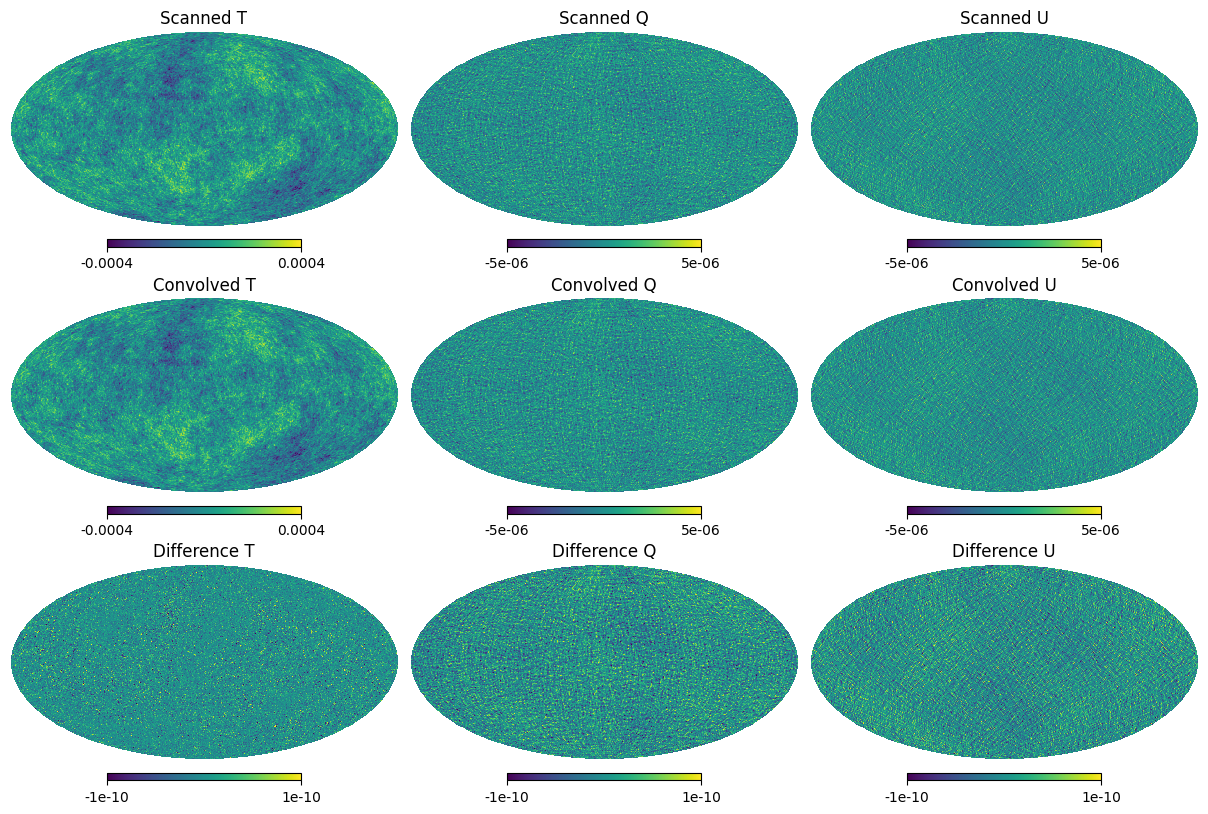

In [17]:
plt.figure(figsize=(12.0, 8.0))

hp.mollview(map_scan[0], title="Scanned T", sub=331, min=-4e-4, max=4e-4)
hp.mollview(map_scan[1], title="Scanned Q", sub=332, min=-5e-6, max=5e-6)
hp.mollview(map_scan[2], title="Scanned U", sub=333, min=-5e-6, max=5e-6)

hp.mollview(map_convolution[0], title="Convolved T", sub=334, min=-4e-4, max=4e-4)
hp.mollview(map_convolution[1], title="Convolved Q", sub=335, min=-5e-6, max=5e-6)
hp.mollview(map_convolution[2], title="Convolved U", sub=336, min=-5e-6, max=5e-6)

hp.mollview(
    map_scan[0] - map_convolution[0], title="Difference T", sub=337, min=-1e-10, max=1e-10
)
hp.mollview(
    map_scan[1] - map_convolution[1], title="Difference Q", sub=338, min=-1e-10, max=1e-10
)
hp.mollview(
    map_scan[2] - map_convolution[2], title="Difference U", sub=339, min=-1e-10, max=1e-10
)

Some mismatch is present, this is cused by the different handling of the sub-pixel signal by scan_map (simple bi-linear interpolation) and convolve_sky (correct interpolation)

Let's see what happens if we center the pointings to the centers of the corresponding HEALPix pixels at the given NSIDE resolution.

## Same run with centered pointing

Let's start nullifying the tods

In [18]:
sim.nullify_tod(components=["scan_map", "convolve_sky"])

We fill the TODs

In this case we pass to [fill_tods](https://litebird-sim.readthedocs.io/en/master/map_scanning.html) a smoothed map.

In [19]:
sim.fill_tods(maps=map_sky, component="scan_map")

sim.convolve_sky(
    sky_alms=alm_sky,
    convolution_params=Convparams,
    component="convolve_sky",
    nside_centering=nside,
)

We do maps

In [20]:
output_scan = sim.make_binned_map(nside=nside, components=["scan_map"])

output_convolution = sim.make_binned_map(nside=nside, components=["convolve_sky"])

map_scan = output_scan.binned_map
map_convolution = output_convolution.binned_map

Finally we compare them

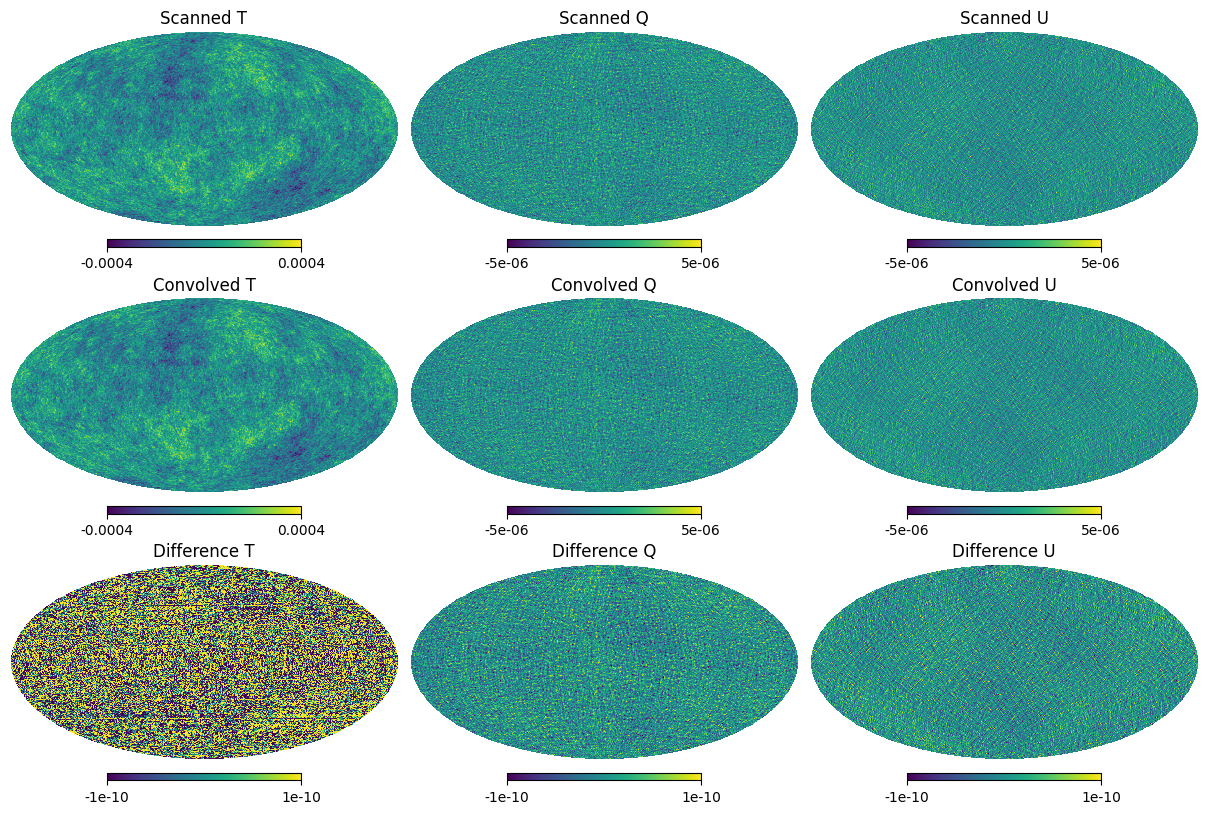

In [21]:
plt.figure(figsize=(12.0, 8.0))

hp.mollview(map_scan[0], title="Scanned T", sub=331, min=-4e-4, max=4e-4)
hp.mollview(map_scan[1], title="Scanned Q", sub=332, min=-5e-6, max=5e-6)
hp.mollview(map_scan[2], title="Scanned U", sub=333, min=-5e-6, max=5e-6)

hp.mollview(map_convolution[0], title="Convolved T", sub=334, min=-4e-4, max=4e-4)
hp.mollview(map_convolution[1], title="Convolved Q", sub=335, min=-5e-6, max=5e-6)
hp.mollview(map_convolution[2], title="Convolved U", sub=336, min=-5e-6, max=5e-6)

hp.mollview(
    map_scan[0] - map_convolution[0], title="Difference T", sub=337, min=-1e-10, max=1e-10
)
hp.mollview(
    map_scan[1] - map_convolution[1], title="Difference Q", sub=338, min=-1e-10, max=1e-10
)
hp.mollview(
    map_scan[2] - map_convolution[2], title="Difference U", sub=339, min=-1e-10, max=1e-10
)